# Feature Sorting and Analyses from augmented data

Most of this code is similar to `10-code.ipynb` file. Where I extract features from my recordings.

In [1]:
import numpy as np
import mne
from scipy import signal
from scipy.interpolate import RectBivariateSpline
from mne.filter import resample, filter_data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lspopt import spectrogram_lspopt
from matplotlib.colors import Normalize, ListedColormap

import logging
LOGGING_TYPES = dict(DEBUG=logging.DEBUG, INFO=logging.INFO, WARNING=logging.WARNING,
                     ERROR=logging.ERROR, CRITICAL=logging.CRITICAL)
logger = logging.getLogger('yasa')

# %matplotlib qt


In [2]:
# load reference_df     
reference_df = pd.read_csv("reference_df.csv", index_col="name")
reference_df.head(3)

,hypno,df_feat,eeg
name,,,
P18_N3 L,/Users/amirhosseindaraie/Desktop/data/synced-h...,feature/P18_N3 L.csv,/Users/amirhosseindaraie/Desktop/data/autoscor...
P18_N2 R,/Users/amirhosseindaraie/Desktop/data/synced-h...,feature/P18_N2 R.csv,/Users/amirhosseindaraie/Desktop/data/autoscor...
P17_N2 L,/Users/amirhosseindaraie/Desktop/data/synced-h...,feature/P17_N2 L.csv,/Users/amirhosseindaraie/Desktop/data/autoscor...


In [3]:
stages_matrix = np.array([[-1,0,1,2,3,4]])

for i in range(0, len(reference_df)):
    # To load information of each night:
    name = reference_df.iloc[i].name
    hypno_30s_loc = reference_df.iloc[i].hypno
    df_feat_loc = reference_df.iloc[i].df_feat
    eeg_loc = reference_df.iloc[i].eeg

    # Make sure to choose the augmented versions:
    hypno_30s_loc = hypno_30s_loc.split(".")[0] + " aug.txt"
    df_feat_loc = df_feat_loc.split(".")[0] + " aug.csv"
    eeg_loc = eeg_loc.split(".")[0] + " aug.txt"

    # Load data of each night
    # data = np.loadtxt(eeg_loc, delimiter=",")  # took ~7 seconds
    hypno_30s = np.loadtxt(hypno_30s_loc, delimiter="\n")

    stages, counts = np.unique(hypno_30s, return_counts=True)
    if -1 not in stages:
        stages = np.insert(stages, 0, -1)
        counts = np.insert(counts, 0, 0)
    if (4 not in stages) and (5 in stages):
        print(f"changing 5 to 4 in {name}")
        stages[-1] = 4  # change 5 to 4
    stages_matrix = np.append(stages_matrix, [counts], axis=0)


In [4]:
stages_matrix.shape

(62, 6)

In [5]:
stages_matrix[:6,:]

array([[ -1,   0,   1,   2,   3,   4],
       [  0, 405, 462, 441, 540, 524],
       [  0, 336, 408, 402, 534, 492],
       [  0, 442, 408, 492, 480, 459],
       [  0, 352,  84, 522, 648, 434],
       [  0, 330, 322, 339, 324, 345]])

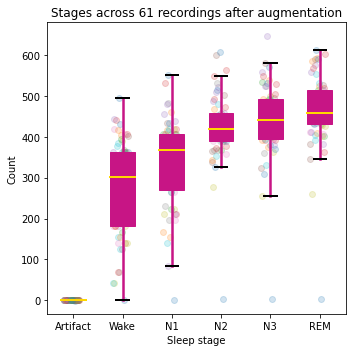

In [6]:
fig, ax = plt.subplots(figsize=[5, 5])
for i in range(stages_matrix.shape[0] - 1):
    ax.scatter(
        stages_matrix[0, :] + np.random.rand() / 3, stages_matrix[i, :], alpha=0.2
    )
ax.set(
    xticks=np.arange(-1 + 0.2, 4 + 1 + 0.2, 1),
    xticklabels=["Artifact", "Wake", "N1", "N2", "N3", "REM"],
)
box1 = ax.boxplot(
    stages_matrix,
    positions=np.arange(-1 + 0.2, 4 + 1 + 0.2, 1),
    manage_ticks=False,
    showfliers=False,
    widths=0.5,
    patch_artist=True,
    medianprops={"linewidth": 2},
    whiskerprops={"linewidth": 2.5},
    capprops={"linewidth": 2},
)
c2 = "purple"
# for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
plt.setp(box1["boxes"], color="mediumvioletred")
plt.setp(box1["whiskers"], color="mediumvioletred")
plt.setp(box1["medians"], color="gold")
plt.title(f"Stages across {stages_matrix.shape[0]-1} recordings after augmentation")
plt.xlabel("Sleep stage")
plt.ylabel("Count")
plt.tight_layout()
# plt.savefig("stage_distribution aug.svg")
# plt.savefig("stage_distribution aug.png")
plt.show()


In [7]:
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from scipy.stats import kruskal
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
def feature_selection_f_classif(x, y):
    """
    Compute the ANOVA F-value for the provided sample.
    Example
    -------
    >>> fvals = feature_selection_f_classif(df_feat, hypno_30s)
    """
    k_best = SelectKBest(f_classif, k="all")
    fit = k_best.fit(x, y)
    # print("Scores: ", fit.scores_)
    # ranking = fit.get_support()
    # print("Ranking: ", ranking)
    # features = fit.transform(x)
    fvals = pd.Series(fit.scores_, index=df_feat.columns).sort_values()
    return fvals


fvals_df = None

for i in range(0, len(reference_df)):

    ### to load augmented hypno:
    name = reference_df.iloc[i].name
    hypno_30s_loc = reference_df.iloc[i].hypno
    hypno_30s_loc = hypno_30s_loc.split(".")[0] + " aug.txt"
    hypno_30s = np.loadtxt(hypno_30s_loc, delimiter="\n")

    ### to load features for augmented eeg:
    df_feat_loc = reference_df.iloc[i].df_feat
    df_feat_loc = df_feat_loc.split(".")[0] + " aug.csv"
    df_feat = pd.read_csv(df_feat_loc, index_col=False)

    df_feat = df_feat.replace(
        [np.inf, -np.inf], 0
    )  # Replacing infinite values in features

    # Compute the ANOVA F-value for the provided sample
    fvals = feature_selection_f_classif(df_feat, hypno_30s)

    # fig = plt.figure(figsize=(10, 10))
    # plt.suptitle(f"ANOVA F-value for features {name} augmented")
    # sns.barplot(y=fvals.index, x=fvals, palette="RdYlGn")
    # plt.xlabel("ANOVA F-value")
    # plt.xticks(rotation=20)
    # plt.yticks(size=8)
    # plt.tight_layout()
    # plt.savefig(f"fs_fclassif figures/fs_fclassif {name} aug.png", format="png")
    # plt.savefig(f"fs_fclassif figures/fs_fclassif {name} aug.svg", format="svg")
    # plt.close(fig)

    fvals["name"] = name

    if fvals_df is None:  # if not exist, then create it
        fvals_df = pd.DataFrame(columns=fvals.index)
        fvals_df = pd.concat([fvals_df, fvals.to_frame().T])
    else:  # fill it
        fvals_df = pd.concat([fvals_df, fvals.to_frame().T])

fvals_df = fvals_df.set_index("name")
fvals_rank_df = fvals_df.rank(1, ascending=False, method="first")


In [9]:
fvals_df.head()

,mean,mean_distance,da,skew,kurt,hmob_psd,kurt_psd,skew_psd,dt,ta,...,sg,ta_b,sb,ag,bubbleEnt1,higuchi,bubbleEnt2,ab,petrosian,perm_entropy
name,,,,,,,,,,,,,,,,,,,,,
P18_N3 L,0.223252,25.590137,27.275912,28.408493,30.576654,36.8426,39.435245,45.805756,47.040069,48.786452,...,1183.65168,1423.197835,1515.621222,1556.49869,1751.58971,1757.8441,1897.729481,2045.894835,2709.05849,2926.698465
P18_N2 R,5.913887,23.970143,73.450493,48.118025,56.719206,8.432759,1.66041,0.361036,76.294723,202.195337,...,470.419116,1414.765928,578.592431,713.574457,843.880418,805.385554,952.176933,927.876178,1048.103701,1147.126445
P17_N2 L,0.570227,52.64239,74.291959,49.760993,20.45055,140.278433,136.434419,122.863525,91.778545,37.92783,...,236.124222,579.452141,794.800837,200.976428,654.729493,662.004587,728.632225,575.226044,612.168142,618.596348
P15_N3 L,3.199534,5.892771,41.08757,34.526369,39.217943,55.605699,60.393595,66.210491,121.659209,213.253374,...,771.612687,936.663385,1049.096029,791.498945,538.42291,296.845845,441.186156,1077.019165,437.844235,455.913648
P15_N2 L,4.936978,11.573213,55.071289,54.972903,22.474102,41.949886,46.426222,49.814354,95.725679,84.146037,...,243.248826,66.695231,270.097877,189.922548,159.31205,292.064967,125.366752,154.808866,237.99865,247.382295


In [10]:
fvals_rank_df.head()

,mean,mean_distance,da,skew,kurt,hmob_psd,kurt_psd,skew_psd,dt,ta,...,sg,ta_b,sb,ag,bubbleEnt1,higuchi,bubbleEnt2,ab,petrosian,perm_entropy
name,,,,,,,,,,,,,,,,,,,,,
P18_N3 L,73.0,72.0,71.0,70.0,69.0,68.0,67.0,66.0,65.0,64.0,...,10.0,9.0,8.0,7.0,6.0,5.0,4.0,3.0,2.0,1.0
P18_N2 R,70.0,63.0,53.0,60.0,57.0,69.0,72.0,73.0,52.0,30.0,...,16.0,1.0,13.0,11.0,8.0,9.0,6.0,7.0,5.0,3.0
P17_N2 L,73.0,63.0,51.0,65.0,72.0,28.0,32.0,38.0,47.0,68.0,...,17.0,7.0,1.0,21.0,4.0,3.0,2.0,8.0,6.0,5.0
P15_N3 L,73.0,72.0,68.0,71.0,69.0,62.0,60.0,57.0,46.0,29.0,...,6.0,3.0,2.0,5.0,9.0,17.0,12.0,1.0,13.0,10.0
P15_N2 L,73.0,72.0,52.0,53.0,71.0,63.0,58.0,55.0,35.0,41.0,...,5.0,48.0,3.0,14.0,18.0,1.0,26.0,19.0,7.0,4.0


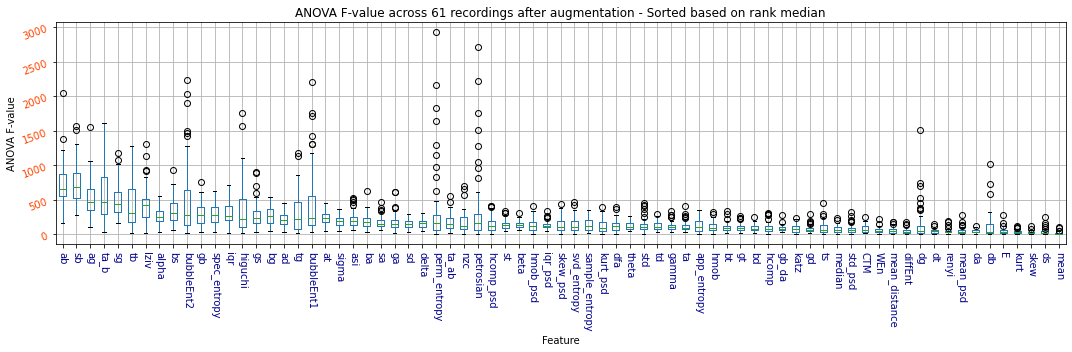

In [11]:
plt.figure(figsize=(15,5))
fvals_df = fvals_df.rename(columns={'central_tendency_measure':"CTM"}) # first name is too long :) so abbreviate it!
fvals_rank_df = fvals_rank_df.rename(columns={'central_tendency_measure':"CTM"})

fvals_df = fvals_df.astype(float)
fvals_df = fvals_df[fvals_rank_df.median().sort_values().index]
ax = fvals_df.boxplot()	
ax.tick_params(
    axis="x", labelsize=10,
    labelrotation=-90,
    labelcolor="darkblue")
ax.tick_params(
    axis="y", labelsize=10,
    labelrotation=20,
    labelcolor="orangered")
plt.xlabel("Feature")
plt.ylabel("ANOVA F-value")
plt.title(f"ANOVA F-value across {reference_df.shape[0]} recordings after augmentation - Sorted based on rank median")
plt.tight_layout()
# plt.savefig("fs_fclassif_ranking aug.png")
# plt.savefig("fs_fclassif_ranking aug.svg")
plt.show()

## Plot signal with the best feature from ANOVA

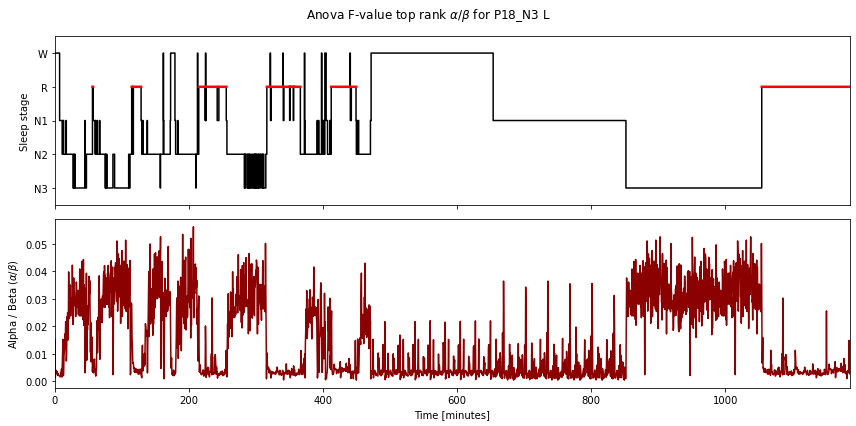

In [12]:
### to load augmented hypno:
name = reference_df.iloc[0].name
hypno_30s_loc = reference_df.iloc[0].hypno
hypno_30s_loc = hypno_30s_loc.split(".")[0] + " aug.txt"
hypno_30s = np.loadtxt(hypno_30s_loc, delimiter="\n")

### to load features for augmented eeg:
df_feat_loc = reference_df.iloc[0].df_feat
df_feat_loc = df_feat_loc.split(".")[0] + " aug.csv"
df_feat = pd.read_csv(df_feat_loc, index_col=False)

### to load augmented eeg:
eeg_loc = reference_df.iloc[0].eeg
eeg_loc = eeg_loc.split(".")[0] + " aug.txt"
data = np.loadtxt(eeg_loc, delimiter=",")  # took ~7 seconds # this is filtered data actually

def sliding_window(data, sf, window, step=None, axis=-1):
    """Calculate a sliding window of a 1D or 2D EEG signal.
    .. versionadded:: 0.1.7
    Parameters
    ----------
    data : numpy array
        The 1D or 2D EEG data.
    sf : float
        The sampling frequency of ``data``.
    window : int
        The sliding window length, in seconds.
    step : int
        The sliding window step length, in seconds.
        If None (default), ``step`` is set to ``window``,
        which results in no overlap between the sliding windows.
    axis : int
        The axis to slide over. Defaults to the last axis.
    Returns
    -------
    times : numpy array
        Time vector, in seconds, corresponding to the START of each sliding
        epoch in ``strided``.
    strided : numpy array
        A matrix where row in last dimension consists of one instance
        of the sliding window, shape (n_epochs, ..., n_samples).
    Notes
    -----
    This is a wrapper around the
    :py:func:`numpy.lib.stride_tricks.as_strided` function.
    Examples
    --------
    With a 1-D array
    >>> import numpy as np
    >>> from yasa import sliding_window
    >>> data = np.arange(20)
    >>> times, epochs = sliding_window(data, sf=1, window=5)
    >>> times
    array([ 0.,  5., 10., 15.])
    >>> epochs
    array([[ 0,  1,  2,  3,  4],
           [ 5,  6,  7,  8,  9],
           [10, 11, 12, 13, 14],
           [15, 16, 17, 18, 19]])
    >>> sliding_window(data, sf=1, window=5, step=1)[1]
    array([[ 0,  1,  2,  3,  4],
           [ 2,  3,  4,  5,  6],
           [ 4,  5,  6,  7,  8],
           [ 6,  7,  8,  9, 10],
           [ 8,  9, 10, 11, 12],
           [10, 11, 12, 13, 14],
           [12, 13, 14, 15, 16],
           [14, 15, 16, 17, 18]])
    >>> sliding_window(data, sf=1, window=11)[1]
    array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])
    With a N-D array
    >>> np.random.seed(42)
    >>> # 4 channels x 20 samples
    >>> data = np.random.randint(-100, 100, size=(4, 20))
    >>> epochs = sliding_window(data, sf=1, window=10)[1]
    >>> epochs.shape  # shape (n_epochs, n_channels, n_samples)
    (2, 4, 10)
    >>> epochs
    array([[[  2,  79,  -8, -86,   6, -29,  88, -80,   2,  21],
            [-13,  57, -63,  29,  91,  87, -80,  60, -43, -79],
            [-50,   7, -46, -37,  30, -50,  34, -80, -28,  66],
            [ -9,  10,  87,  98,  71, -93,  74, -66, -20,  63]],
           [[-26, -13,  16,  -1,   3,  51,  30,  49, -48, -99],
            [-12, -52, -42,  69,  87, -86,  89,  89,  74,  89],
            [-83,  31, -12, -41, -87, -92, -11, -48,  29, -17],
            [-51,   3,  31, -99,  33, -47,   5, -97, -47,  90]]])
    """
    from numpy.lib.stride_tricks import as_strided

    assert axis <= data.ndim, "Axis value out of range."
    assert isinstance(sf, (int, float)), "sf must be int or float"
    assert isinstance(window, (int, float)), "window must be int or float"
    assert isinstance(step, (int, float, type(None))), (
        "step must be int, " "float or None."
    )
    if isinstance(sf, float):
        assert sf.is_integer(), "sf must be a whole number."
        sf = int(sf)
    assert isinstance(axis, int), "axis must be int."

    # window and step in samples instead of points
    window *= sf
    step = window if step is None else step * sf

    if isinstance(window, float):
        assert window.is_integer(), "window * sf must be a whole number."
        window = int(window)

    if isinstance(step, float):
        assert step.is_integer(), "step * sf must be a whole number."
        step = int(step)

    assert step >= 1, "Stepsize may not be zero or negative."
    assert window < data.shape[axis], (
        "Sliding window size may not exceed " "size of selected axis"
    )

    # Define output shape
    shape = list(data.shape)
    shape[axis] = np.floor(data.shape[axis] / step - window / step + 1).astype(int)
    shape.append(window)

    # Calculate strides and time vector
    strides = list(data.strides)
    strides[axis] *= step
    strides.append(data.strides[axis])
    strided = as_strided(data, shape=shape, strides=strides)
    t = np.arange(strided.shape[-2]) * (step / sf)

    # Swap axis: n_epochs, ..., n_samples
    if strided.ndim > 2:
        strided = np.rollaxis(strided, -2, 0)
    return t, strided


# Convert the EEG data to 30-sec data
times, data_win = sliding_window(data.flatten(), 256, window=30)

# Convert times to minutes
times /= 60

# Plot hypnogram and a feature
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

fig.suptitle(f'Anova F-value top rank $\\alpha/\\beta$ for {name}')

hypno = pd.Series(hypno_30s).map({-1: -1, 0: 0, 1: 2, 2: 3, 3: 4, 4: 1}).values
hypno_rem = np.ma.masked_not_equal(hypno, 1)

# Plot the hypnogram
ax1.step(times, -1 * hypno, color="k", lw=1.5)
ax1.step(times, -1 * hypno_rem, color="r", lw=2.5)
ax1.set_yticks([0, -1, -2, -3, -4])
ax1.set_yticklabels(["W", "R", "N1", "N2", "N3"])
ax1.set_ylim(-4.5, 0.5)
ax1.set_ylabel("Sleep stage")

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

# Plot the non-linear feature
ax2.plot(times, normalize(df_feat["ab"]), color="darkred")
ax2.set_ylabel("Alpha / Beta ($\\alpha/\\beta$)")
ax2.set_xlabel("Time [minutes]")
ax2.set_xlim(0, times[-1])

plt.tight_layout()
# plt.savefig(f"fs_fclassif_rank1 {name} aug.png")
# plt.savefig(f"fs_fclassif_rank1 {name} aug.svg")
plt.show()


# Mutual Information

In [13]:
def feature_selection_mutual_info(x, y, k=10):
    """
    Preforms feature selection using the select_k_best with mutual_info_classif.
    Mutual information measures how much information the presence/absence of a feature contributes to making the correct prediction on Y.
    Recieves
    --------
        x -> feature dataframe
        y -> labels
        k -> number of remaining features
    Returns:
        keep_features -> list with the naime of the choosen features
    """
    clf = SelectKBest(mutual_info_classif, k=k)
    fit = clf.fit(x, y)
    fvals = pd.Series(fit.scores_, index=df_feat.columns).sort_values()
    return fvals


MI_df = None

for i in range(0, len(reference_df)):

    ### to load augmented hypno:
    name = reference_df.iloc[i].name
    hypno_30s_loc = reference_df.iloc[i].hypno
    hypno_30s_loc = hypno_30s_loc.split(".")[0] + " aug.txt"
    hypno_30s = np.loadtxt(hypno_30s_loc, delimiter="\n")

    ### to load features for augmented eeg:
    df_feat_loc = reference_df.iloc[i].df_feat
    df_feat_loc = df_feat_loc.split(".")[0] + " aug.csv"
    df_feat = pd.read_csv(df_feat_loc, index_col=False)

    df_feat = df_feat.replace(
        [np.inf, -np.inf], 0
    )  # Replacing infinite values in features

    # Compute the estimated mutual information between each feature and the target for the provided sample
    MI = feature_selection_mutual_info(df_feat, hypno_30s, 10)

    # Plot features ranking
    # fig = plt.figure(figsize=(10, 10))
    # plt.suptitle(f"Mutual Information between each feature and sleep stage {name} augmented")
    # sns.barplot(y=MI.index, x=MI, palette="RdYlGn")
    # plt.xlabel("Estimated mutual information")
    # plt.xticks(rotation=20)
    # plt.yticks(size=8)
    # plt.tight_layout()
    # plt.savefig(f"fs_MI figures/fs_MI {name} aug.png", format="png")
    # plt.savefig(f"fs_MI figures/fs_MI {name} aug.svg", format="svg")
    # plt.close(fig)

    MI["name"] = name

    if MI_df is None:  # if not exist, then create it
        MI_df = pd.DataFrame(columns=MI.index)
        MI_df = pd.concat([MI_df, MI.to_frame().T])
    else:  # fill it
        MI_df = pd.concat([MI_df, MI.to_frame().T])


MI_df = MI_df.set_index("name")
MI_rank_df = MI_df.rank(1, ascending=False, method="first")


In [14]:
MI_df.head(3)

,mean_distance,hcomp_psd,skew_psd,hmob_psd,kurt_psd,katz,dfa,mean_psd,std_psd,td,...,renyi,WEn,mean,skew,E,median,iqr,std,petrosian,perm_entropy
name,,,,,,,,,,,,,,,,,,,,,
P18_N3 L,0.211338,0.246725,0.271675,0.282052,0.324608,0.373121,0.436804,0.4502,0.459463,0.496464,...,1.12344,1.126432,1.128465,1.128527,1.147656,1.163211,1.173403,1.1771,1.223675,1.299644
P18_N2 R,0.283674,0.249627,0.3465,0.256686,0.323094,0.324581,0.387752,0.381337,0.416559,0.471588,...,0.780303,0.834223,0.77954,0.841361,0.823743,0.844759,1.062659,0.969671,1.139769,1.180844
P17_N2 L,0.27942,0.389277,0.458032,0.405593,0.450888,0.277636,0.389504,0.513575,0.503826,0.59021,...,1.247852,1.232179,1.238713,1.310943,1.246087,1.299722,1.262995,1.302429,0.951949,1.055631


In [15]:
MI_rank_df.head(3)

,mean_distance,hcomp_psd,skew_psd,hmob_psd,kurt_psd,katz,dfa,mean_psd,std_psd,td,...,renyi,WEn,mean,skew,E,median,iqr,std,petrosian,perm_entropy
name,,,,,,,,,,,,,,,,,,,,,
P18_N3 L,73.0,72.0,71.0,70.0,69.0,68.0,67.0,66.0,65.0,64.0,...,10.0,9.0,8.0,7.0,6.0,5.0,4.0,3.0,2.0,1.0
P18_N2 R,71.0,73.0,68.0,72.0,70.0,69.0,66.0,67.0,65.0,62.0,...,19.0,10.0,20.0,9.0,13.0,8.0,4.0,5.0,2.0,1.0
P17_N2 L,72.0,71.0,67.0,69.0,68.0,73.0,70.0,65.0,66.0,55.0,...,5.0,8.0,7.0,1.0,6.0,3.0,4.0,2.0,14.0,12.0


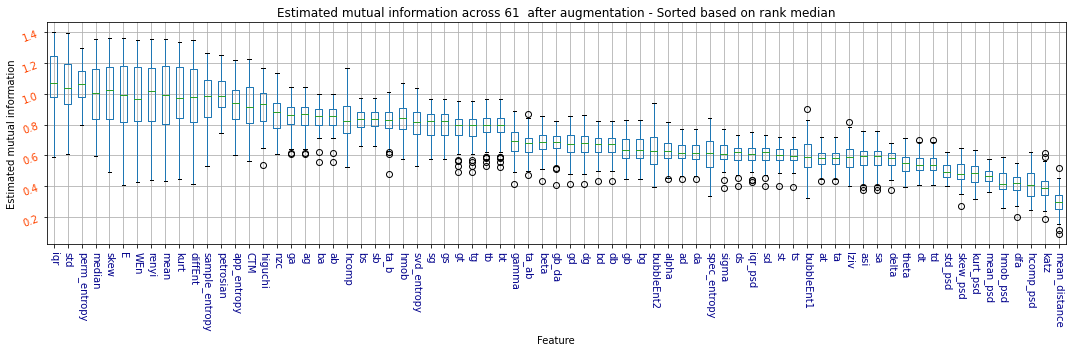

In [16]:
plt.figure(figsize=(15,5))
MI_df = MI_df.rename(columns={'central_tendency_measure':"CTM"}) # first name is too long :) so abbreviate it!
MI_rank_df = MI_rank_df.rename(columns={'central_tendency_measure':"CTM"})

MI_df = MI_df.astype(float)
MI_df = MI_df[MI_rank_df.median().sort_values().index]
ax = MI_df.boxplot()	
ax.tick_params(
    axis="x", labelsize=10,
    labelrotation=-90,
    labelcolor="darkblue")
ax.tick_params(
    axis="y", labelsize=10,
    labelrotation=20,
    labelcolor="orangered")
plt.xlabel("Feature")
plt.ylabel("Estimated mutual information")
plt.title(f"Estimated mutual information across {reference_df.shape[0]}  after augmentation - Sorted based on rank median")
plt.tight_layout()
# plt.savefig("fs_MI_ranking aug.png")
# plt.savefig("fs_MI_ranking aug.svg")
plt.show()

# Chi-squared

In [13]:
def minMaxScaler_f(df, feature_range=(0, 1)):
    """
    Example
    -------
    >>> df = pd.DataFrame( {"col1": [1, 3, 5, 7, 9], "col2": [7, 4, 35, 14, 56]} )
    >>> df = minMaxScaler_f(df)
    """
    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler(feature_range)

    df_scaled = scaler.fit_transform(df.to_numpy())
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

    return df_scaled


def feature_selection_chi_squared(x, y):
    # Chi Squared
    # Feature extraction
    test = SelectKBest(score_func=chi2, k=10)
    fit = test.fit(x, y)
    # Summarize scores
    # np.set_printoptions(precision=3)
    # print(fit.scores_)
    # ranking = fit.get_support()
    # print("Ranking: ", ranking)
    # Summarize selected features
    # features = fit.transform(x)
    fvals = pd.Series(fit.scores_, index=df_feat.columns).sort_values()
    return fvals


chiSqr_df = None

for i in range(0, len(reference_df)):

    ### to load augmented hypno:
    name = reference_df.iloc[i].name
    hypno_30s_loc = reference_df.iloc[i].hypno
    hypno_30s_loc = hypno_30s_loc.split(".")[0] + " aug.txt"
    hypno_30s = np.loadtxt(hypno_30s_loc, delimiter="\n")

    ### to load features for augmented eeg:
    df_feat_loc = reference_df.iloc[i].df_feat
    df_feat_loc = df_feat_loc.split(".")[0] + " aug.csv"
    df_feat = pd.read_csv(df_feat_loc, index_col=False)

    df_feat = df_feat.replace(
        [np.inf, -np.inf], 0
    )  # Replacing infinite values in features

    # Compute the estimated mutual information between each feature and the target for the provided sample
    chiSqr = feature_selection_chi_squared(minMaxScaler_f(df_feat), hypno_30s)

    # Plot features ranking
    # fig = plt.figure(figsize=(10, 10))
    # plt.suptitle(f"Chi-squared stats of non-negative features {name} augmented")
    # sns.barplot(y=chiSqr.index, x=chiSqr, palette="RdYlGn")
    # plt.xlabel("Chi sqaured F-values")
    # plt.xticks(rotation=20)
    # plt.yticks(size=8)
    # plt.tight_layout()
    # plt.savefig(f"fs_chiSQR figures/fs_chiSQR {name} aug.png", format="png")
    # plt.savefig(f"fs_chiSQR figures/fs_chiSQR {name} aug.svg", format="svg")
    # plt.close(fig)

    chiSqr["name"] = name

    if chiSqr_df is None:  # if not exist, then create it
        chiSqr_df = pd.DataFrame(columns=chiSqr.index)
        chiSqr_df = pd.concat([chiSqr_df, chiSqr.to_frame().T])
    else:  # fill it
        chiSqr_df = pd.concat([chiSqr_df, chiSqr.to_frame().T])

chiSqr_df = chiSqr_df.set_index("name")
chiSqr_rank_df = chiSqr_df.rank(1, ascending=False, method="first")


In [14]:
chiSqr_df.head(3)

,mean,mean_distance,skew,ta_ab,hmob_psd,skew_psd,kurt_psd,ta,WEn,ts,...,gs,perm_entropy,petrosian,higuchi,sg,bubbleEnt1,bubbleEnt2,sb,ag,ab
name,,,,,,,,,,,,,,,,,,,,,
P18_N3 L,0.016531,0.695521,2.453133,6.356649,6.534039,7.007762,7.504197,8.518665,11.160281,11.281604,...,223.700736,225.930085,238.373947,256.818957,288.10917,317.553189,338.706553,342.414999,364.596766,472.02564
P18_N2 R,0.145264,0.768623,2.316427,53.435771,2.305482,0.098899,0.511337,58.359182,3.603307,70.566942,...,125.24527,168.731899,175.28268,192.366907,147.626124,209.370915,229.675899,148.639694,196.714511,302.631542
P17_N2 L,0.003335,0.997231,1.263917,22.510367,27.283719,10.954252,18.524156,9.199244,5.960506,15.147496,...,141.998669,125.918788,134.286938,191.577219,79.023339,130.041046,148.916435,231.467104,66.327363,179.297405


In [15]:
chiSqr_rank_df.head(3)

,mean,mean_distance,skew,ta_ab,hmob_psd,skew_psd,kurt_psd,ta,WEn,ts,...,gs,perm_entropy,petrosian,higuchi,sg,bubbleEnt1,bubbleEnt2,sb,ag,ab
name,,,,,,,,,,,,,,,,,,,,,
P18_N3 L,73.0,72.0,71.0,70.0,69.0,68.0,67.0,66.0,65.0,64.0,...,10.0,9.0,8.0,7.0,6.0,5.0,4.0,3.0,2.0,1.0
P18_N2 R,72.0,70.0,66.0,42.0,67.0,73.0,71.0,39.0,64.0,33.0,...,17.0,12.0,11.0,10.0,15.0,8.0,7.0,14.0,9.0,2.0
P17_N2 L,73.0,72.0,71.0,50.0,46.0,66.0,55.0,68.0,70.0,62.0,...,7.0,11.0,8.0,2.0,23.0,9.0,6.0,1.0,28.0,3.0


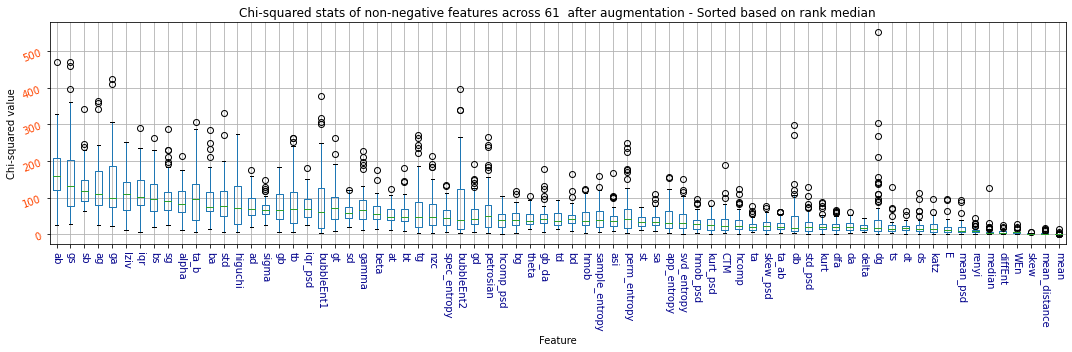

In [16]:
plt.figure(figsize=(15,5))
chiSqr_df = chiSqr_df.rename(columns={'central_tendency_measure':"CTM"}) # first name is too long :) so abbreviate it!
chiSqr_rank_df = chiSqr_rank_df.rename(columns={'central_tendency_measure':"CTM"})

chiSqr_df = chiSqr_df.astype(float)
chiSqr_df = chiSqr_df[chiSqr_rank_df.median().sort_values().index]
ax = chiSqr_df.boxplot()	
ax.tick_params(
    axis="x", labelsize=10,
    labelrotation=-90,
    labelcolor="darkblue")
ax.tick_params(
    axis="y", labelsize=10,
    labelrotation=20,
    labelcolor="orangered")
plt.xlabel("Feature")
plt.ylabel("Chi-squared value")
plt.title(f"Chi-squared stats of non-negative features across {reference_df.shape[0]}  after augmentation - Sorted based on rank median")
plt.tight_layout()
plt.savefig("fs_chiSQR_ranking.png")
plt.savefig("fs_chiSQR_ranking.svg")
plt.show()



In [21]:
# create a ranking dictionary that contain feature selection algorithm and a list of features with the classification significance order
fvals_df = fvals_df[fvals_rank_df.mean().sort_values().index]
f1 = dict(zip(fvals_df.columns.values.tolist(), range(1,75+1)))
f1 = pd.Series(f1, index=f1.keys())
f1["method_name"] = "f_classif"
f1 = f1.sort_index(ascending=True)
f1 = f1.to_frame()
f1 = f1.T

MI_df = MI_df[MI_rank_df.mean().sort_values().index]
f2 = dict(zip(MI_df.columns.values.tolist(), range(1,75+1)))
f2 = pd.Series(f2, index=f2.keys())
f2["method_name"] = "MI"
f2 = f2.sort_index(ascending=True)
f2 = f2.to_frame()
f2 = f2.T

chiSqr_df = chiSqr_df[chiSqr_rank_df.mean().sort_values().index]
f3 = dict(zip(chiSqr_df.columns.values.tolist(), range(1,75+1)))
f3 = pd.Series(f3, index=f3.keys())
f3["method_name"] = "chiSqr"
f3 = f3.sort_index(ascending=True)
f3 = f3.to_frame()
f3 = f3.T

rankings_df = pd.concat([f1, f2, f3])
rankings_df = rankings_df.set_index("method_name")

In [22]:
rankings_df.head()

,CTM,E,WEn,ab,ad,ag,alpha,app_entropy,asi,at,...,std_psd,svd_entropy,ta,ta_ab,ta_b,tb,td,tg,theta,ts
method_name,,,,,,,,,,,,,,,,,,,,,
f_classif,59,66,62,2,18,3,8,47,20,16,...,60,41,46,29,5,10,42,22,36,54
MI,16,9,11,19,46,18,44,13,60,56,...,65,29,57,37,23,31,62,33,64,52
chiSqr,52,65,70,1,14,4,10,44,42,25,...,54,46,56,57,12,20,37,28,36,61


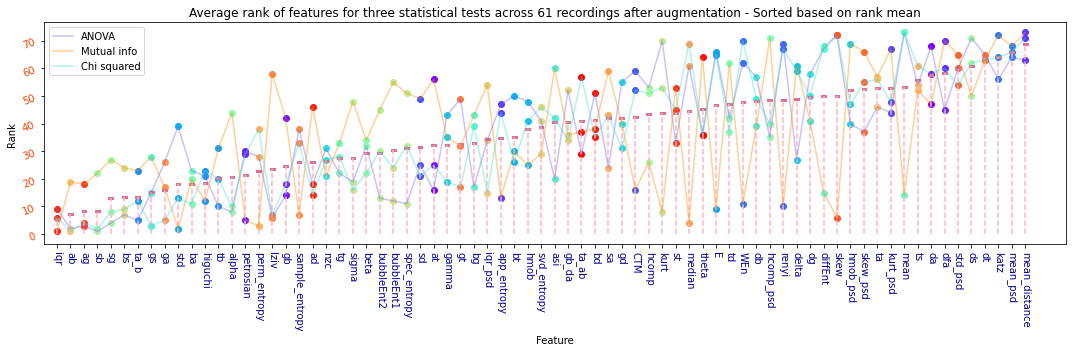

In [23]:
rankings_df = rankings_df.astype(float)
rankings_df = rankings_df[rankings_df.mean().sort_values().index] # ***** columns sorted here based on mean over three tests

fig, ax = plt.subplots(figsize=(15, 5))

from matplotlib.pyplot import cm, xticks

color = cm.rainbow(np.linspace(0, 1, 75))
np.random.shuffle(color)
color = iter(color)

for i in range(73):
    c = next(color)
    ax.scatter(i, rankings_df.to_numpy()[0, i], color=c)
    ax.scatter(i, rankings_df.to_numpy()[1, i], color=c)
    ax.scatter(i, rankings_df.to_numpy()[2, i], color=c)
    pnts = np.array(
        [
            rankings_df.to_numpy()[0, i],
            rankings_df.to_numpy()[1, i],
            rankings_df.to_numpy()[2, i],
        ]
    )
    ax.plot(
        [i - 0.1, i + 0.1],
        [np.mean(pnts), np.mean(pnts)],
        "-",
        color="palevioletred",
        linewidth=3,
    )
    ax.plot([i, i], [0, np.mean(pnts)], "--", color="lightpink")

ax.plot(
    range(73),
    rankings_df.to_numpy()[0, :],
    linewidth=1.5,
    alpha=0.4,
    color="mediumslateblue",
    label="ANOVA",
)
ax.plot(
    range(73),
    rankings_df.to_numpy()[1, :],
    linewidth=1.5,
    alpha=0.4,
    color="darkorange",
    label="Mutual info",
)
ax.plot(
    range(73),
    rankings_df.to_numpy()[2, :],
    linewidth=1.5,
    alpha=0.4,
    color="turquoise",
    label="Chi squared",
)

ax.set(xlabel="Feature", ylabel="Rank", xlim=[-1, 75])
plt.title(
    f"Average rank of features for three statistical tests across {reference_df.shape[0]} recordings after augmentation - Sorted based on rank mean"
)
ax.set(xticks=range(73), xticklabels=rankings_df.columns.values.tolist())
ax.tick_params(axis="x", labelsize=10, labelrotation=-90, labelcolor="darkblue")
ax.tick_params(axis="y", labelsize=10, labelrotation=20, labelcolor="orangered")
plt.legend()
plt.tight_layout()
# plt.savefig("fs_overall_ranking aug.png")
# plt.savefig("fs_overall_ranking aug.svg")
plt.show()


In [24]:
# write to csv    
rankings_df = rankings_df.rename(columns={'CTM':"central_tendency_measure"}) # return CTM back to standard central_tendency_measure
rankings_df.to_csv("rankings_df aug.csv")

In [25]:
# load csv    
rankings_df = pd.read_csv("rankings_df aug.csv", index_col="method_name")

In [26]:
rankings_df.head()

,iqr,ab,ag,sb,sg,bs,ta_b,gs,ga,std,...,mean,ts,da,dfa,std_psd,ds,dt,katz,mean_psd,mean_distance
method_name,,,,,,,,,,,,,,,,,,,,,
f_classif,9.0,2.0,3.0,1.0,4.0,7.0,5.0,15.0,26.0,39.0,...,73.0,54.0,68.0,45.0,60.0,71.0,65.0,56.0,64.0,63.0
MI,1.0,19.0,18.0,22.0,27.0,24.0,23.0,28.0,17.0,2.0,...,14.0,52.0,47.0,70.0,65.0,50.0,63.0,72.0,68.0,73.0
chiSqr,6.0,1.0,4.0,2.0,8.0,9.0,12.0,3.0,5.0,13.0,...,73.0,61.0,58.0,60.0,54.0,62.0,63.0,64.0,66.0,71.0
